## 필요한 라이브러리 임폴트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('font', family='NanumGothic')
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

## 데이터 불러오기

In [3]:
data = pd.read_csv('final_data.csv')
data

,광역시도명,시군구명,날짜,시간대별 시간,강수 유형명,습도값,강수량 값,기온값,풍속값,한식_배달건수,...,찜탕_배달건수,도시락_배달건수,패스트푸드_배달건수,가장 많은 배달,년도,월,일,요일,계절,불쾌지수
0,0,4,2019-07-12,18,0,0.91,0.0,22.6,1.5,0,...,0,0,0,8,2019,7,12,4,1,71.95334
1,0,4,2019-07-19,21,0,0.63,0.0,28.6,2.1,0,...,0,0,0,4,2019,7,19,4,1,78.29482
2,0,4,2019-07-22,12,0,0.92,0.0,25.9,1.0,0,...,0,0,0,5,2019,7,22,0,1,77.71272
3,0,4,2019-07-22,15,0,0.96,0.0,24.4,0.1,0,...,0,0,1,9,2019,7,22,0,1,75.52576
4,0,4,2019-07-22,18,0,0.94,0.0,24.7,0.6,0,...,0,0,0,8,2019,7,22,0,1,75.85082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129288,2,19,2020-07-31,19,1,0.98,1.0,24.4,0.8,36,...,5,0,6,11,2020,7,31,4,1,75.72288
129289,2,19,2020-07-31,20,0,0.98,0.0,24.4,1.1,36,...,9,0,6,11,2020,7,31,4,1,75.72288
129290,2,19,2020-07-31,21,0,0.97,0.0,24.8,1.5,36,...,1,0,3,11,2020,7,31,4,1,76.33244
129291,2,19,2020-07-31,22,0,0.95,0.0,25.2,1.9,18,...,0,0,0,11,2020,7,31,4,1,76.82760


In [4]:
## 모델링을 위한 컬럼 지정

# 적용 전체 컬럼
a = ['광역시도명','시군구명','시간대별 시간','강수 유형명','습도값','강수량 값',
     '기온값','풍속값','가장 많은 배달','년도','월','일','요일','계절','불쾌지수']

# '강수량 값','불쾌지수' --> 상관관계가 강한 컬럼 삭제
b = ['시군구명','시간대별 시간','강수 유형명','습도값','기온값',
     '풍속값','가장 많은 배달','월','일','요일','계절']

## 모든 함수 통합

In [5]:
## 정확도 함수

def make_score(model,xtrain, xtest, ytrain, ytest):
    ypred = model.predict(xtest)
    accuracy = accuracy_score(ytest, ypred)
    return f'정확도 {round(accuracy,4)}'

## Feature_importances 함수

def make_fi(model,x):
    
    ## Feature_importances 추출
    importances = model.feature_importances_
    importances_series = pd.Series(data = importances, index = x.columns)
    importances_series.sort_values(ascending = False).plot(kind = 'bar')
    plt.show()
    
    return

## DecisionTree 함수

def make_dt(data):
    x = data.drop(columns = ['가장 많은 배달'])
    y = data['가장 많은 배달']
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25,
                                                    stratify = y, random_state = 99)
    model = DecisionTreeClassifier().fit(xtrain, ytrain)
    result = make_score(model,xtrain, xtest, ytrain, ytest)
    print(f'DT 정확도 :', result)
    print(f'DT Feature_importances')
    make_fi(model,x)
    
    return 

## RandomForest 함수

def make_rf(data, grid = False):
    x = data.drop(columns = ['가장 많은 배달'])
    y = data['가장 많은 배달']
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25,
                                                    stratify = y, random_state = 99)
    
    ## 그리드 미적용
    if grid == False:
        model = RandomForestClassifier().fit(xtrain, ytrain)
        result = make_score(model,xtrain, xtest, ytrain, ytest)
        print(f'RF 정확도 :', result)
        print(f'RF Feature_importances')
        make_fi(model,x)
    
    ## 그리드 적용
    elif grid == True:
        for n in np.arange(100,300,50):
            model = RandomForestClassifier(n_estimators = n).fit(xtrain, ytrain)
            result = make_score(model, xtrain, xtest, ytrain, ytest)
            print(f'RF_{n} 정확도: ', result)
            
    return 

## XGB 함수

def make_xgb(data, incheon = False, grid = False):
    x = data.drop(columns = ['가장 많은 배달'])
    y = data['가장 많은 배달']
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25,
                                                    stratify = y, random_state = 99)
    
    ## 인천 데이터 y_label 라벨링
    if incheon == True:
        le = LabelEncoder()
        ytrain = le.fit_transform(ytrain)
    else:
        None
        
    ## 그리드 미적용
    if grid == False:
        model = XGBClassifier().fit(xtrain, ytrain)
        result = make_score(model,xtrain, xtest, ytrain, ytest)
        print(f'XGB 정확도 :', result)
        print(f'XGB Feature_importances')
        make_fi(model,x)
    
    ## 그리드 적용
    elif grid == True:
        for n in np.arange(100,300,50):
            for d in np.arange(3,8):
                for l in np.arange(0.1, 0.2, 0.25):
                    model = XGBClassifier(n_estimators = n, max_depth = d, learning_rate = l).fit(xtrain, ytrain)
                    result = make_score(model, xtrain, xtest, ytrain, ytest)
                    print(f'XGB_{n}_{d}_{l} 정확도: ', result)
    
    return 

## LGBM 함수

def make_lgbm(data, grid = False):
    x = data.drop(columns = ['가장 많은 배달'])
    y = data['가장 많은 배달']
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25,
                                                    stratify = y, random_state = 99)
    
    ## 그리드 미적용
    if grid == False:
        model = LGBMClassifier().fit(xtrain, ytrain)
        result = make_score(model,xtrain, xtest, ytrain, ytest)
        print(f'LGBM 정확도 :', result)
        print(f'LGBM Feature_importances')
        make_fi(model,x)
    
    ## 그리드 적용
    elif grid == True:
        for n in np.arange(100,300,50):
            for d in np.arange(3,8):
                for l in np.arange(0.1, 0.2, 0.25):
                    model = LGBMClassifier(n_estimators = n, max_depth = d, learning_rate = l).fit(xtrain, ytrain)
                    result = make_score(model, xtrain, xtest, ytrain, ytest)
                    print(f'LGBM_{n}_{d}_{l} 정확도: ', result)
    
    
    return 

### 정확도 함수

In [79]:
## 정확도 함수
def make_score(model,xtrain, xtest, ytrain, ytest):
    ypred = model.predict(xtest)
    accuracy = accuracy_score(ytest, ypred)
    return f'정확도 {round(accuracy,4)}'

### 1. DecisionTree

In [ ]:
# 데이터의 개수가 적을 수록 높은 정확도 

In [39]:
## DecisionTree 함수
def make_dt(data):
    x = data.drop(columns = ['가장 많은 배달'])
    y = data['가장 많은 배달']
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25,
                                                    stratify = y, random_state = 99)
    model = DecisionTreeClassifier().fit(xtrain, ytrain)
    result = make_score(model,xtrain, xtest, ytrain, ytest)
    print(f'DT 정확도 :', result)
    print(f'DT Feature_importances')
    make_fi(model,x)
    
    return 

### 2. RandomForest

In [ ]:
# 의사결정 트리(DecisionTree)의 오버피팅 한계를 극복하기 위한 전략
# 하이퍼 파라미터 : n_estimators

In [40]:
## DecisionTree 함수
def make_rf(data, grid = False):
    x = data.drop(columns = ['가장 많은 배달'])
    y = data['가장 많은 배달']
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25,
                                                    stratify = y, random_state = 99)
    
    ## 그리드 미적용
    if grid == False:
        model = RandomForestClassifier().fit(xtrain, ytrain)
        result = make_score(model,xtrain, xtest, ytrain, ytest)
        print(f'RF 정확도 :', result)
        print(f'RF Feature_importances')
        make_fi(model,x)
    
    ## 그리드 적용
    elif grid == True:
        for n in np.arange(100,300,50):
            model = RandomForestClassifier(n_estimators = n).fit(xtrain, ytrain)
            result = make_score(model, xtrain, xtest, ytrain, ytest)
            print(f'RF_{n} 정확도: ', result)
            
    return 

### 3. Xgboost

In [24]:
# 최적화된 그레디언트 부스팅 : 빠른 속도, 확장성, 이식성
# 과소적합한 샘플에 가중치를 줘서 다음 모델에서 예측 정확도 높이는 방식인 부스팅 기법
# 하이퍼 파리미터 : n_estimators, max_depth, learning_rate

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [73]:
## XGB 함수

def make_xgb(data, incheon = False, grid = False):
    x = data.drop(columns = ['가장 많은 배달'])
    y = data['가장 많은 배달']
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25,
                                                    stratify = y, random_state = 99)
    
    ## 인천 데이터 y_label 라벨링
    if incheon == True:
        le = LabelEncoder()
        ytrain = le.fit_transform(ytrain)
    else:
        None
        
    ## 그리드 미적용
    if grid == False:
        model = XGBClassifier().fit(xtrain, ytrain)
        result = make_score(model,xtrain, xtest, ytrain, ytest)
        print(f'XGB 정확도 :', result)
        print(f'XGB Feature_importances')
        make_fi(model,x)
    
    ## 그리드 적용
    elif grid == True:
        for n in np.arange(100,300,50):
            for d in np.arange(3,8):
                for l in np.arange(0.1, 0.2, 0.25):
                    model = XGBClassifier(n_estimators = n, max_depth = d, learning_rate = l).fit(xtrain, ytrain)
                    result = make_score(model, xtrain, xtest, ytrain, ytest)
                    print(f'XGB_{n}_{d}_{l} 정확도: ', result)
    
    return 

### 4. LightGBM

In [ ]:
# XGBoost에 비해 훈련 시간이 짧고 성능이 좋은 부스팅 알고리즘
# 대용량 데이터 처리 가능, 메모리 사용량 상대적으로 적음
# 하이퍼 파라미터 : num_iterations, max_depth, learning_rate

In [59]:
## LGBM 함수

def make_lgbm(data, grid = False):
    x = data.drop(columns = ['가장 많은 배달'])
    y = data['가장 많은 배달']
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25,
                                                    stratify = y, random_state = 99)
    
    ## 그리드 미적용
    if grid == False:
        model = LGBMClassifier().fit(xtrain, ytrain)
        result = make_score(model,xtrain, xtest, ytrain, ytest)
        print(f'LGBM 정확도 :', result)
        print(f'LGBM Feature_importances')
        make_fi(model,x)
    
    ## 그리드 적용
    elif grid == True:
        for n in np.arange(100,300,50):
            for d in np.arange(3,8):
                for l in np.arange(0.1, 0.2, 0.25):
                    model = LGBMClassifier(n_estimators = n, max_depth = d, learning_rate = l).fit(xtrain, ytrain)
                    result = make_score(model, xtrain, xtest, ytrain, ytest)
                    print(f'LGBM_{n}_{d}_{l} 정확도: ', result)
    
    
    return 

### 5. Feature_importances

In [ ]:
# 특성 컬럼에서 중요도를 표현 

In [43]:
## Feature_importances 함수
def make_fi(model,x):
    
    ## Feature_importances 추출
    importances = model.feature_importances_
    importances_series = pd.Series(data = importances, index = x.columns)
    importances_series.sort_values(ascending = False).plot(kind = 'bar')
    plt.show()
    
    return

### 6. 모델 적용

In [ ]:
'''
feature_importances 파악을 위해 서울, 경기, 인천의 통합 데이터만 컬럼 분류
광역시도별 feature_importances는 참고용
'''

#### 1). 서울, 경기, 인천 통합 모든 컬럼 모델 적용

In [6]:
## 데이터 추출
data1 = data[a]

DT 정확도 : 정확도 0.4746
DT Feature_importances


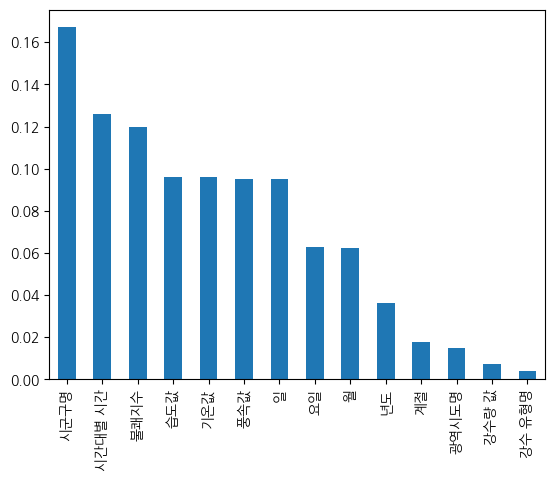

--------------------------------------------------------------------------------
RF 정확도 : 정확도 0.5407
RF Feature_importances


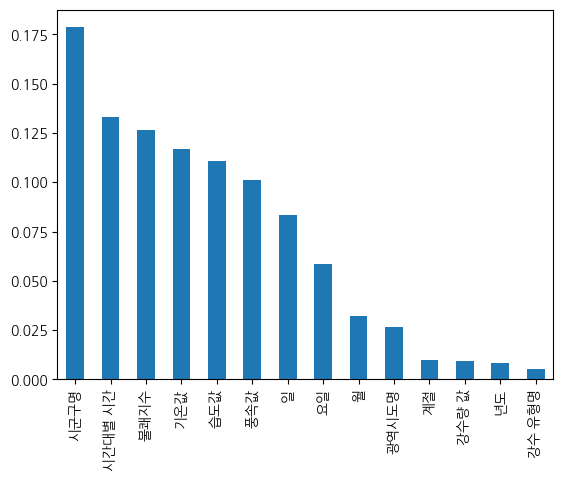

--------------------------------------------------------------------------------
XGB 정확도 : 정확도 0.5775
XGB Feature_importances


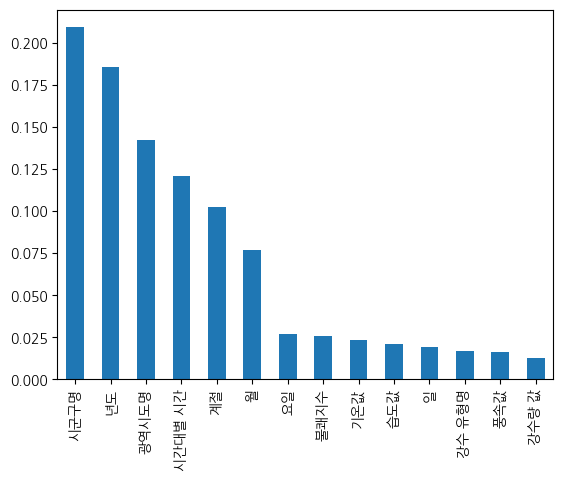

--------------------------------------------------------------------------------
LGBM 정확도 : 정확도 0.5764
LGBM Feature_importances


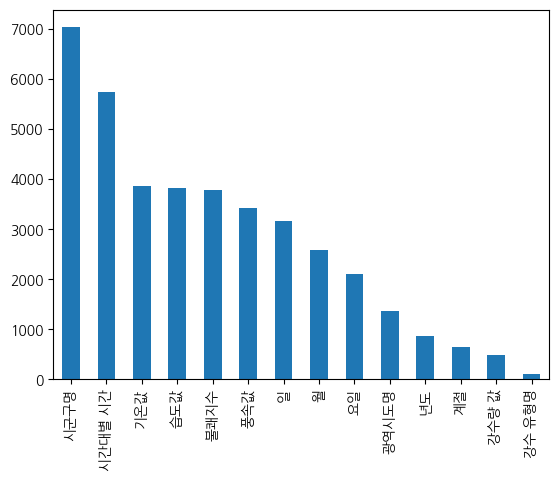

In [7]:
### 그리드 적용 x

## DecisionTree
make_dt(data1)

print('-'*80)

## RandomForest
make_rf(data1, grid = False)

print('-'*80)

## Xgboost
make_xgb(data1, grid = False)

print('-'*80)

## Lgbm
make_lgbm(data1, grid = False)

## 결과
'''
DT 정확도 : 정확도 0.4746
RF 정확도 : 정확도 0.5407
XGB 정확도 : 정확도 0.5775
LGBM 정확도 : 정확도 0.5764
'''

In [8]:
### 그리드 적용

## RandomForest
make_rf(data1, grid = True)

print('-'*80)

## Xgboost
make_xgb(data1, grid = True)

print('-'*80)

## Lgbm
make_lgbm(data1, grid = True)

## 결과
'''
RF_100 정확도:  정확도 0.5391
RF_150 정확도:  정확도 0.5428
RF_200 정확도:  정확도 0.5426
RF_250 정확도:  정확도 0.5409
-------------------------------------
XGB_100_3_0.1 정확도:  정확도 0.5018
XGB_100_4_0.1 정확도:  정확도 0.5364
XGB_100_5_0.1 정확도:  정확도 0.5536
XGB_100_6_0.1 정확도:  정확도 0.5682
XGB_100_7_0.1 정확도:  정확도 0.577
XGB_150_3_0.1 정확도:  정확도 0.5125
XGB_150_4_0.1 정확도:  정확도 0.5447
XGB_150_5_0.1 정확도:  정확도 0.564
XGB_150_6_0.1 정확도:  정확도 0.5739
XGB_150_7_0.1 정확도:  정확도 0.5782
XGB_200_3_0.1 정확도:  정확도 0.5213
XGB_200_4_0.1 정확도:  정확도 0.5523
XGB_200_5_0.1 정확도:  정확도 0.5674
XGB_200_6_0.1 정확도:  정확도 0.576
XGB_200_7_0.1 정확도:  정확도 0.5809
XGB_250_3_0.1 정확도:  정확도 0.528
XGB_250_4_0.1 정확도:  정확도 0.5569
XGB_250_5_0.1 정확도:  정확도 0.5716
XGB_250_6_0.1 정확도:  정확도 0.5787
XGB_250_7_0.1 정확도:  정확도 0.5809
--------------------------------------
LGBM_100_3_0.1 정확도:  정확도 0.5222
LGBM_100_4_0.1 정확도:  정확도 0.5524
LGBM_100_5_0.1 정확도:  정확도 0.5662
LGBM_100_6_0.1 정확도:  정확도 0.5719
LGBM_100_7_0.1 정확도:  정확도 0.5749
LGBM_150_3_0.1 정확도:  정확도 0.534
LGBM_150_4_0.1 정확도:  정확도 0.5597
LGBM_150_5_0.1 정확도:  정확도 0.5707
LGBM_150_6_0.1 정확도:  정확도 0.5761
LGBM_150_7_0.1 정확도:  정확도 0.5793
LGBM_200_3_0.1 정확도:  정확도 0.5414
LGBM_200_4_0.1 정확도:  정확도 0.565
LGBM_200_5_0.1 정확도:  정확도 0.5745
LGBM_200_6_0.1 정확도:  정확도 0.5775
LGBM_200_7_0.1 정확도:  정확도 0.5788
LGBM_250_3_0.1 정확도:  정확도 0.5473
LGBM_250_4_0.1 정확도:  정확도 0.5689
LGBM_250_5_0.1 정확도:  정확도 0.5747
LGBM_250_6_0.1 정확도:  정확도 0.5781
LGBM_250_7_0.1 정확도:  정확도 0.5779
'''

RF_100 정확도:  정확도 0.5391
RF_150 정확도:  정확도 0.5428
RF_200 정확도:  정확도 0.5426
RF_250 정확도:  정확도 0.5409
--------------------------------------------------------------------------------
XGB_100_3_0.1 정확도:  정확도 0.5018
XGB_100_4_0.1 정확도:  정확도 0.5364
XGB_100_5_0.1 정확도:  정확도 0.5536
XGB_100_6_0.1 정확도:  정확도 0.5682
XGB_100_7_0.1 정확도:  정확도 0.577
XGB_150_3_0.1 정확도:  정확도 0.5125
XGB_150_4_0.1 정확도:  정확도 0.5447
XGB_150_5_0.1 정확도:  정확도 0.564
XGB_150_6_0.1 정확도:  정확도 0.5739
XGB_150_7_0.1 정확도:  정확도 0.5782
XGB_200_3_0.1 정확도:  정확도 0.5213
XGB_200_4_0.1 정확도:  정확도 0.5523
XGB_200_5_0.1 정확도:  정확도 0.5674
XGB_200_6_0.1 정확도:  정확도 0.576
XGB_200_7_0.1 정확도:  정확도 0.5809
XGB_250_3_0.1 정확도:  정확도 0.528
XGB_250_4_0.1 정확도:  정확도 0.5569
XGB_250_5_0.1 정확도:  정확도 0.5716
XGB_250_6_0.1 정확도:  정확도 0.5787
XGB_250_7_0.1 정확도:  정확도 0.5809
--------------------------------------------------------------------------------
LGBM_100_3_0.1 정확도:  정확도 0.5222
LGBM_100_4_0.1 정확도:  정확도 0.5524
LGBM_100_5_0.1 정확도:  정확도 0.5662
LGBM_100_6_0.1 정확도:  정확도 0.571

#### 2). 서울, 경기, 인천 최종 확정 컬럼 적용

In [9]:
## 데이터 추출
data2 = data[b]

DT 정확도 : 정확도 0.4724
DT Feature_importances


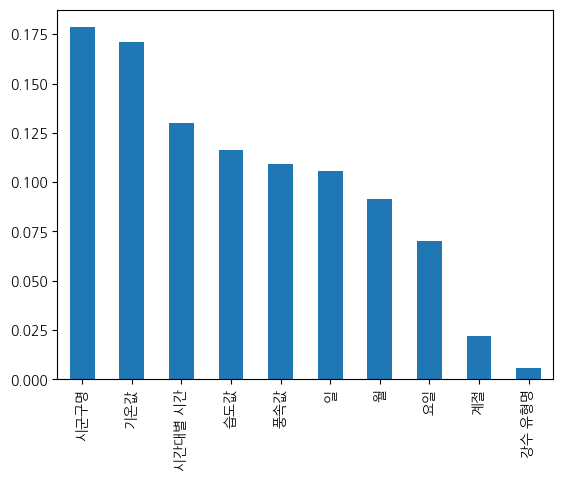

--------------------------------------------------------------------------------
RF 정확도 : 정확도 0.5373
RF Feature_importances


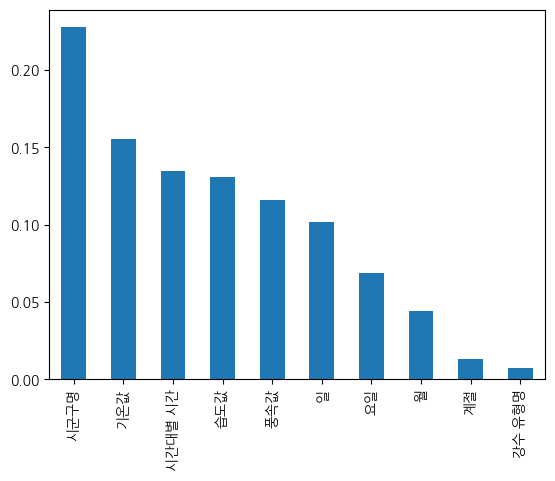

--------------------------------------------------------------------------------
XGB 정확도 : 정확도 0.5742
XGB Feature_importances


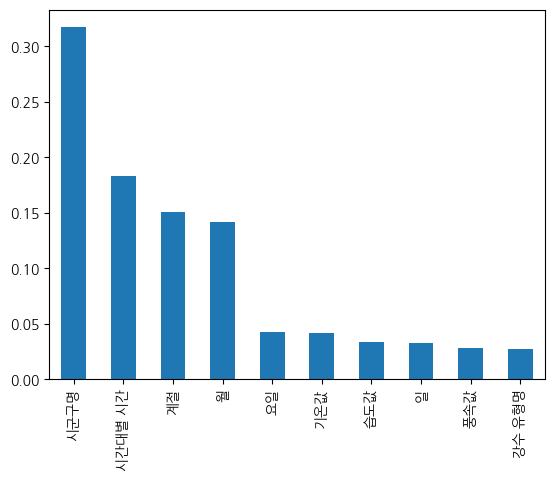

--------------------------------------------------------------------------------
LGBM 정확도 : 정확도 0.5724
LGBM Feature_importances


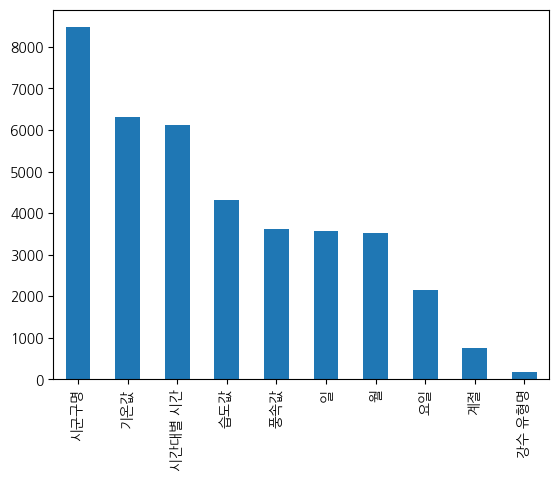

In [10]:
### 그리드 적용 x

## DecisionTree
make_dt(data2)

print('-'*80)

## RandomForest
make_rf(data2, grid = False)

print('-'*80)

## Xgboost
make_xgb(data2, grid = False)

print('-'*80)

## Lgbm
make_lgbm(data2, grid = False)

## 결과
'''
DT 정확도 : 정확도 0.4724
RF 정확도 : 정확도 0.5373
XGB 정확도 : 정확도 0.5742
LGBM 정확도 : 정확도 0.5724
'''

In [11]:
### 그리드 적용

## RandomForest
make_rf(data2, grid = True)

print('-'*80)

## Xgboost
make_xgb(data2, grid = True)

print('-'*80)

## Lgbm
make_lgbm(data2, grid = True)

## 결과
'''
RF_100 정확도:  정확도 0.5364
RF_150 정확도:  정확도 0.539
RF_200 정확도:  정확도 0.5411
RF_250 정확도:  정확도 0.5403
-------------------------------------
XGB_100_3_0.1 정확도:  정확도 0.4933
XGB_100_4_0.1 정확도:  정확도 0.5242
XGB_100_5_0.1 정확도:  정확도 0.5487
XGB_100_6_0.1 정확도:  정확도 0.5628
XGB_100_7_0.1 정확도:  정확도 0.5722
XGB_150_3_0.1 정확도:  정확도 0.5088
XGB_150_4_0.1 정확도:  정확도 0.5361
XGB_150_5_0.1 정확도:  정확도 0.5554
XGB_150_6_0.1 정확도:  정확도 0.5687
XGB_150_7_0.1 정확도:  정확도 0.5775
XGB_200_3_0.1 정확도:  정확도 0.5149
XGB_200_4_0.1 정확도:  정확도 0.543
XGB_200_5_0.1 정확도:  정확도 0.5609
XGB_200_6_0.1 정확도:  정확도 0.5731
XGB_200_7_0.1 정확도:  정확도 0.5795
XGB_250_3_0.1 정확도:  정확도 0.5218
XGB_250_4_0.1 정확도:  정확도 0.5481
XGB_250_5_0.1 정확도:  정확도 0.564
XGB_250_6_0.1 정확도:  정확도 0.5737
XGB_250_7_0.1 정확도:  정확도 0.5793
--------------------------------------
LGBM_100_3_0.1 정확도:  정확도 0.5165
LGBM_100_4_0.1 정확도:  정확도 0.5422
LGBM_100_5_0.1 정확도:  정확도 0.5587
LGBM_100_6_0.1 정확도:  정확도 0.568
LGBM_100_7_0.1 정확도:  정확도 0.5718
LGBM_150_3_0.1 정확도:  정확도 0.5267
LGBM_150_4_0.1 정확도:  정확도 0.5523
LGBM_150_5_0.1 정확도:  정확도 0.5683
LGBM_150_6_0.1 정확도:  정확도 0.5725
LGBM_150_7_0.1 정확도:  정확도 0.5759
LGBM_200_3_0.1 정확도:  정확도 0.5323
LGBM_200_4_0.1 정확도:  정확도 0.5578
LGBM_200_5_0.1 정확도:  정확도 0.5706
LGBM_200_6_0.1 정확도:  정확도 0.5737
LGBM_200_7_0.1 정확도:  정확도 0.5762
LGBM_250_3_0.1 정확도:  정확도 0.5397
LGBM_250_4_0.1 정확도:  정확도 0.5629
LGBM_250_5_0.1 정확도:  정확도 0.5712
LGBM_250_6_0.1 정확도:  정확도 0.5741
LGBM_250_7_0.1 정확도:  정확도 0.5777
'''

RF_100 정확도:  정확도 0.5364
RF_150 정확도:  정확도 0.539
RF_200 정확도:  정확도 0.5411
RF_250 정확도:  정확도 0.5403
--------------------------------------------------------------------------------
XGB_100_3_0.1 정확도:  정확도 0.4933
XGB_100_4_0.1 정확도:  정확도 0.5242
XGB_100_5_0.1 정확도:  정확도 0.5487
XGB_100_6_0.1 정확도:  정확도 0.5628
XGB_100_7_0.1 정확도:  정확도 0.5722
XGB_150_3_0.1 정확도:  정확도 0.5088
XGB_150_4_0.1 정확도:  정확도 0.5361
XGB_150_5_0.1 정확도:  정확도 0.5554
XGB_150_6_0.1 정확도:  정확도 0.5687
XGB_150_7_0.1 정확도:  정확도 0.5775
XGB_200_3_0.1 정확도:  정확도 0.5149
XGB_200_4_0.1 정확도:  정확도 0.543
XGB_200_5_0.1 정확도:  정확도 0.5609
XGB_200_6_0.1 정확도:  정확도 0.5731
XGB_200_7_0.1 정확도:  정확도 0.5795
XGB_250_3_0.1 정확도:  정확도 0.5218
XGB_250_4_0.1 정확도:  정확도 0.5481
XGB_250_5_0.1 정확도:  정확도 0.564
XGB_250_6_0.1 정확도:  정확도 0.5737
XGB_250_7_0.1 정확도:  정확도 0.5793
--------------------------------------------------------------------------------
LGBM_100_3_0.1 정확도:  정확도 0.5165
LGBM_100_4_0.1 정확도:  정확도 0.5422
LGBM_100_5_0.1 정확도:  정확도 0.5587
LGBM_100_6_0.1 정확도:  정확도 0.56

#### 3). 서울

In [12]:
## 데이터 추출
se = data[data['광역시도명'] == 1]
se = se[b].reset_index(drop = True)

DT 정확도 : 정확도 0.5098
DT Feature_importances


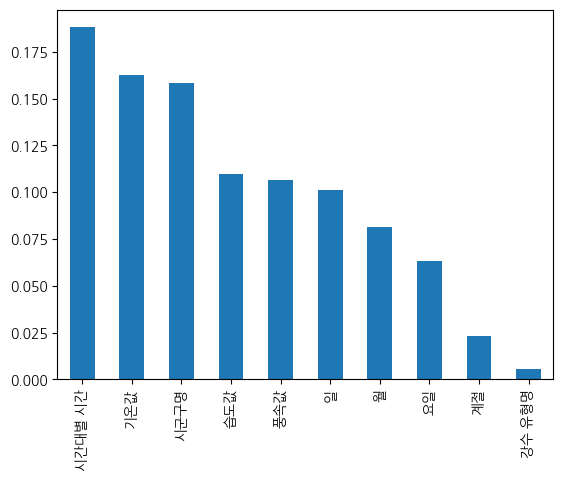

--------------------------------------------------------------------------------
RF 정확도 : 정확도 0.6005
RF Feature_importances


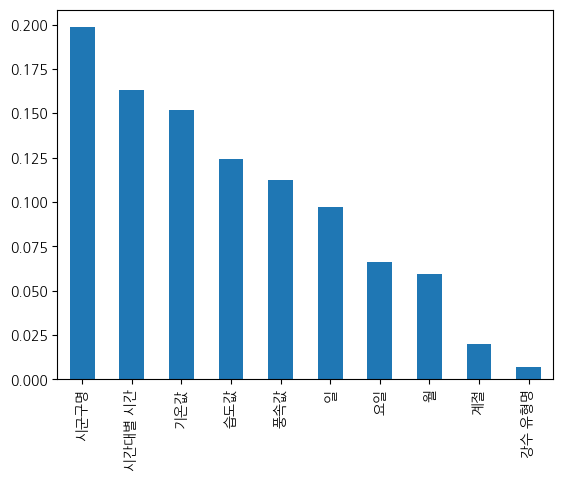

--------------------------------------------------------------------------------
XGB 정확도 : 정확도 0.6082
XGB Feature_importances


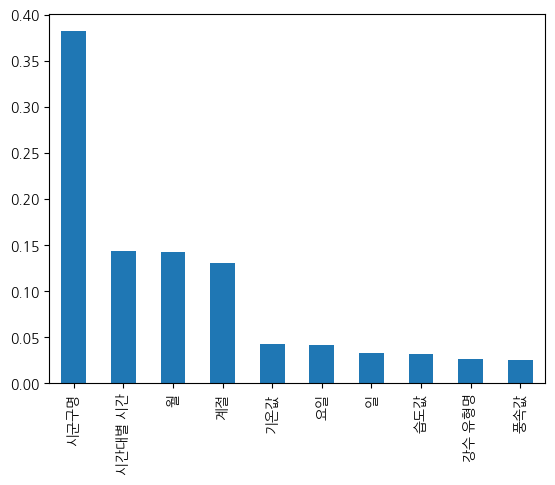

--------------------------------------------------------------------------------
LGBM 정확도 : 정확도 0.6179
LGBM Feature_importances


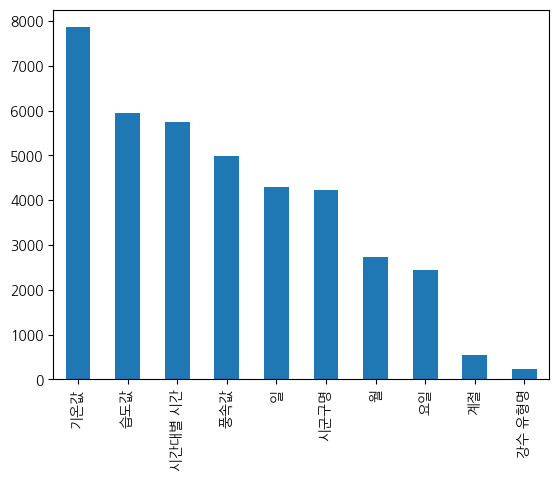

In [13]:
### 그리드 적용 x

## DecisionTree
make_dt(se)

print('-'*80)

## RandomForest
make_rf(se, grid = False)

print('-'*80)

## Xgboost
make_xgb(se, grid = False)

print('-'*80)

## Lgbm
make_lgbm(se, grid = False)

## 결과
'''
DT 정확도 : 정확도 0.5098
RF 정확도 : 정확도 0.6005
XGB 정확도 : 정확도 0.6082
LGBM 정확도 : 정확도 0.6179
'''

In [14]:
### 그리드 적용

## RandomForest
make_rf(se, grid = True)

print('-'*80)

## Xgboost
make_xgb(se, grid = True)

print('-'*80)

## Lgbm
make_lgbm(se, grid = True)

## 결과
'''
RF_100 정확도:  정확도 0.5969
RF_150 정확도:  정확도 0.6013
RF_200 정확도:  정확도 0.599
RF_250 정확도:  정확도 0.6026
--------------------------------------------------------------------------------
XGB_100_3_0.1 정확도:  정확도 0.5794
XGB_100_4_0.1 정확도:  정확도 0.5914
XGB_100_5_0.1 정확도:  정확도 0.6036
XGB_100_6_0.1 정확도:  정확도 0.6141
XGB_100_7_0.1 정확도:  정확도 0.6157
XGB_150_3_0.1 정확도:  정확도 0.5858
XGB_150_4_0.1 정확도:  정확도 0.5977
XGB_150_5_0.1 정확도:  정확도 0.6081
XGB_150_6_0.1 정확도:  정확도 0.6137
XGB_150_7_0.1 정확도:  정확도 0.6164
XGB_200_3_0.1 정확도:  정확도 0.59
XGB_200_4_0.1 정확도:  정확도 0.6003
XGB_200_5_0.1 정확도:  정확도 0.6083
XGB_200_6_0.1 정확도:  정확도 0.6129
XGB_200_7_0.1 정확도:  정확도 0.6182
XGB_250_3_0.1 정확도:  정확도 0.5918
XGB_250_4_0.1 정확도:  정확도 0.6038
XGB_250_5_0.1 정확도:  정확도 0.6082
XGB_250_6_0.1 정확도:  정확도 0.6111
XGB_250_7_0.1 정확도:  정확도 0.6161
--------------------------------------------------------------------------------
LGBM_100_3_0.1 정확도:  정확도 0.5905
LGBM_100_4_0.1 정확도:  정확도 0.5991
LGBM_100_5_0.1 정확도:  정확도 0.6076
LGBM_100_6_0.1 정확도:  정확도 0.6144
LGBM_100_7_0.1 정확도:  정확도 0.6167
LGBM_150_3_0.1 정확도:  정확도 0.5949
LGBM_150_4_0.1 정확도:  정확도 0.6033
LGBM_150_5_0.1 정확도:  정확도 0.6088
LGBM_150_6_0.1 정확도:  정확도 0.6155
LGBM_150_7_0.1 정확도:  정확도 0.6145
LGBM_200_3_0.1 정확도:  정확도 0.5964
LGBM_200_4_0.1 정확도:  정확도 0.6026
LGBM_200_5_0.1 정확도:  정확도 0.6103
LGBM_200_6_0.1 정확도:  정확도 0.6142
LGBM_200_7_0.1 정확도:  정확도 0.6158
LGBM_250_3_0.1 정확도:  정확도 0.5999
LGBM_250_4_0.1 정확도:  정확도 0.6072
LGBM_250_5_0.1 정확도:  정확도 0.6119
LGBM_250_6_0.1 정확도:  정확도 0.6115
LGBM_250_7_0.1 정확도:  정확도 0.6137
'''

RF_100 정확도:  정확도 0.5969
RF_150 정확도:  정확도 0.6013
RF_200 정확도:  정확도 0.599
RF_250 정확도:  정확도 0.6026
--------------------------------------------------------------------------------
XGB_100_3_0.1 정확도:  정확도 0.5794
XGB_100_4_0.1 정확도:  정확도 0.5914
XGB_100_5_0.1 정확도:  정확도 0.6036
XGB_100_6_0.1 정확도:  정확도 0.6141
XGB_100_7_0.1 정확도:  정확도 0.6157
XGB_150_3_0.1 정확도:  정확도 0.5858
XGB_150_4_0.1 정확도:  정확도 0.5977
XGB_150_5_0.1 정확도:  정확도 0.6081
XGB_150_6_0.1 정확도:  정확도 0.6137
XGB_150_7_0.1 정확도:  정확도 0.6164
XGB_200_3_0.1 정확도:  정확도 0.59
XGB_200_4_0.1 정확도:  정확도 0.6003
XGB_200_5_0.1 정확도:  정확도 0.6083
XGB_200_6_0.1 정확도:  정확도 0.6129
XGB_200_7_0.1 정확도:  정확도 0.6182
XGB_250_3_0.1 정확도:  정확도 0.5918
XGB_250_4_0.1 정확도:  정확도 0.6038
XGB_250_5_0.1 정확도:  정확도 0.6082
XGB_250_6_0.1 정확도:  정확도 0.6111
XGB_250_7_0.1 정확도:  정확도 0.6161
--------------------------------------------------------------------------------
LGBM_100_3_0.1 정확도:  정확도 0.5905
LGBM_100_4_0.1 정확도:  정확도 0.5991
LGBM_100_5_0.1 정확도:  정확도 0.6076
LGBM_100_6_0.1 정확도:  정확도 0.61

#### 4). 경기

In [15]:
gy = data[data['광역시도명'] == 0]
gy = gy[b].reset_index(drop = True)

DT 정확도 : 정확도 0.4472
DT Feature_importances


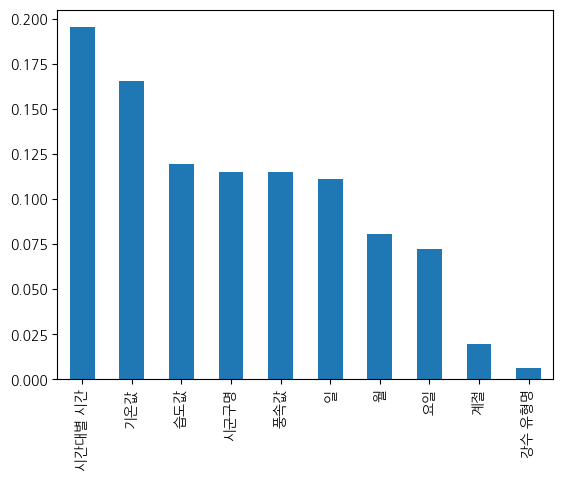

--------------------------------------------------------------------------------
RF 정확도 : 정확도 0.516
RF Feature_importances


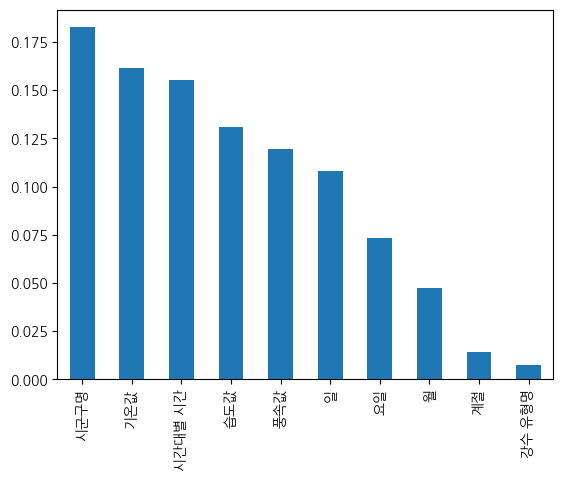

--------------------------------------------------------------------------------
XGB 정확도 : 정확도 0.5425
XGB Feature_importances


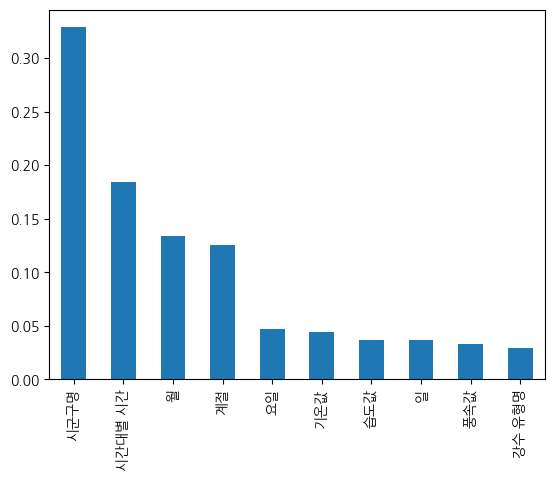

--------------------------------------------------------------------------------
LGBM 정확도 : 정확도 0.5465
LGBM Feature_importances


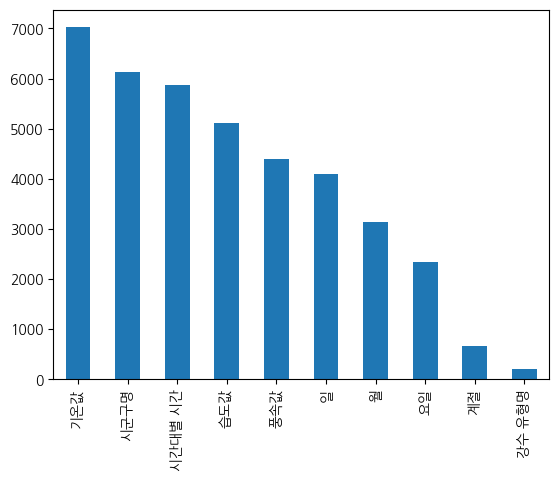

In [16]:
### 그리드 적용 x

## DecisionTree
make_dt(gy)

print('-'*80)

## RandomForest
make_rf(gy, grid = False)

print('-'*80)

## Xgboost
make_xgb(gy, grid = False)

print('-'*80)

## Lgbm
make_lgbm(gy, grid = False)

## 결과
'''
DT 정확도 : 정확도 0.4472
RF 정확도 : 정확도 0.516
XGB 정확도 : 정확도 0.5425
LGBM 정확도 : 정확도 0.5465
'''

In [17]:
### 그리드 적용

## RandomForest
make_rf(gy, grid = True)

print('-'*80)

## Xgboost
make_xgb(gy, grid = True)

print('-'*80)

## Lgbm
make_lgbm(gy, grid = True)

## 결과
'''
RF_100 정확도:  정확도 0.5157
RF_150 정확도:  정확도 0.5187
RF_200 정확도:  정확도 0.517
RF_250 정확도:  정확도 0.517
--------------------------------------------------------------------------------
XGB_100_3_0.1 정확도:  정확도 0.4858
XGB_100_4_0.1 정확도:  정확도 0.5169
XGB_100_5_0.1 정확도:  정확도 0.5334
XGB_100_6_0.1 정확도:  정확도 0.5434
XGB_100_7_0.1 정확도:  정확도 0.547
XGB_150_3_0.1 정확도:  정확도 0.5023
XGB_150_4_0.1 정확도:  정확도 0.5256
XGB_150_5_0.1 정확도:  정확도 0.5395
XGB_150_6_0.1 정확도:  정확도 0.5447
XGB_150_7_0.1 정확도:  정확도 0.549
XGB_200_3_0.1 정확도:  정확도 0.5101
XGB_200_4_0.1 정확도:  정확도 0.5306
XGB_200_5_0.1 정확도:  정확도 0.5411
XGB_200_6_0.1 정확도:  정확도 0.5441
XGB_200_7_0.1 정확도:  정확도 0.5482
XGB_250_3_0.1 정확도:  정확도 0.5148
XGB_250_4_0.1 정확도:  정확도 0.5332
XGB_250_5_0.1 정확도:  정확도 0.5405
XGB_250_6_0.1 정확도:  정확도 0.5442
XGB_250_7_0.1 정확도:  정확도 0.5463
--------------------------------------------------------------------------------
LGBM_100_3_0.1 정확도:  정확도 0.5075
LGBM_100_4_0.1 정확도:  정확도 0.5275
LGBM_100_5_0.1 정확도:  정확도 0.5391
LGBM_100_6_0.1 정확도:  정확도 0.5426
LGBM_100_7_0.1 정확도:  정확도 0.5439
LGBM_150_3_0.1 정확도:  정확도 0.5204
LGBM_150_4_0.1 정확도:  정확도 0.5349
LGBM_150_5_0.1 정확도:  정확도 0.5418
LGBM_150_6_0.1 정확도:  정확도 0.5421
LGBM_150_7_0.1 정확도:  정확도 0.5441
LGBM_200_3_0.1 정확도:  정확도 0.5243
LGBM_200_4_0.1 정확도:  정확도 0.5361
LGBM_200_5_0.1 정확도:  정확도 0.5424
LGBM_200_6_0.1 정확도:  정확도 0.5425
LGBM_200_7_0.1 정확도:  정확도 0.5435
LGBM_250_3_0.1 정확도:  정확도 0.5271
LGBM_250_4_0.1 정확도:  정확도 0.5373
LGBM_250_5_0.1 정확도:  정확도 0.5444
LGBM_250_6_0.1 정확도:  정확도 0.5418
LGBM_250_7_0.1 정확도:  정확도 0.5433
'''

RF_100 정확도:  정확도 0.5157
RF_150 정확도:  정확도 0.5187
RF_200 정확도:  정확도 0.517
RF_250 정확도:  정확도 0.517
--------------------------------------------------------------------------------
XGB_100_3_0.1 정확도:  정확도 0.4858
XGB_100_4_0.1 정확도:  정확도 0.5169
XGB_100_5_0.1 정확도:  정확도 0.5334
XGB_100_6_0.1 정확도:  정확도 0.5434
XGB_100_7_0.1 정확도:  정확도 0.547
XGB_150_3_0.1 정확도:  정확도 0.5023
XGB_150_4_0.1 정확도:  정확도 0.5256
XGB_150_5_0.1 정확도:  정확도 0.5395
XGB_150_6_0.1 정확도:  정확도 0.5447
XGB_150_7_0.1 정확도:  정확도 0.549
XGB_200_3_0.1 정확도:  정확도 0.5101
XGB_200_4_0.1 정확도:  정확도 0.5306
XGB_200_5_0.1 정확도:  정확도 0.5411
XGB_200_6_0.1 정확도:  정확도 0.5441
XGB_200_7_0.1 정확도:  정확도 0.5482
XGB_250_3_0.1 정확도:  정확도 0.5148
XGB_250_4_0.1 정확도:  정확도 0.5332
XGB_250_5_0.1 정확도:  정확도 0.5405
XGB_250_6_0.1 정확도:  정확도 0.5442
XGB_250_7_0.1 정확도:  정확도 0.5463
--------------------------------------------------------------------------------
LGBM_100_3_0.1 정확도:  정확도 0.5075
LGBM_100_4_0.1 정확도:  정확도 0.5275
LGBM_100_5_0.1 정확도:  정확도 0.5391
LGBM_100_6_0.1 정확도:  정확도 0.542

#### 5). 인천

In [18]:
ic = data[data['광역시도명'] == 2]
ic = ic[b].reset_index(drop = True).drop(columns = ['시군구명'])
print(ic)

      시간대별 시간  강수 유형명   습도값   기온값  풍속값  가장 많은 배달  월   일  요일  계절
0          10       0  0.93  23.2  0.1         8  7   4   3   1
1          13       0  0.98  20.6  0.0         8  7   4   3   1
2          14       0  0.98  20.0  0.1         8  7   4   3   1
3          15       0  0.98  19.6  0.0         8  7   4   3   1
4          16       0  0.98  18.8  0.0         8  7   4   3   1
...       ...     ...   ...   ...  ...       ... ..  ..  ..  ..
6554       19       1  0.98  24.4  0.8        11  7  31   4   1
6555       20       0  0.98  24.4  1.1        11  7  31   4   1
6556       21       0  0.97  24.8  1.5        11  7  31   4   1
6557       22       0  0.95  25.2  1.9        11  7  31   4   1
6558       23       0  0.96  25.3  1.4        11  7  31   4   1

[6559 rows x 10 columns]


DT 정확도 : 정확도 0.6152
DT Feature_importances


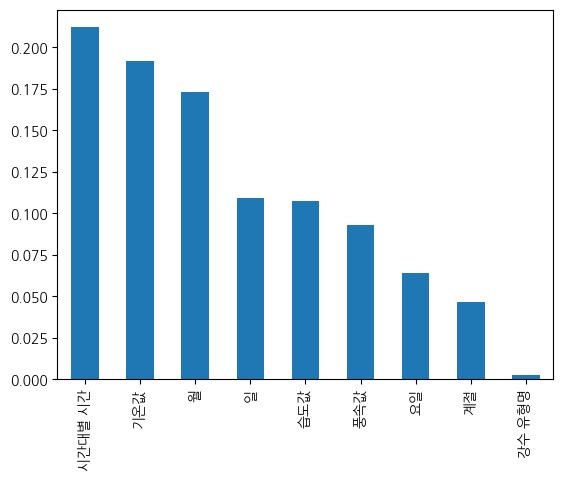

--------------------------------------------------------------------------------
RF 정확도 : 정확도 0.6848
RF Feature_importances


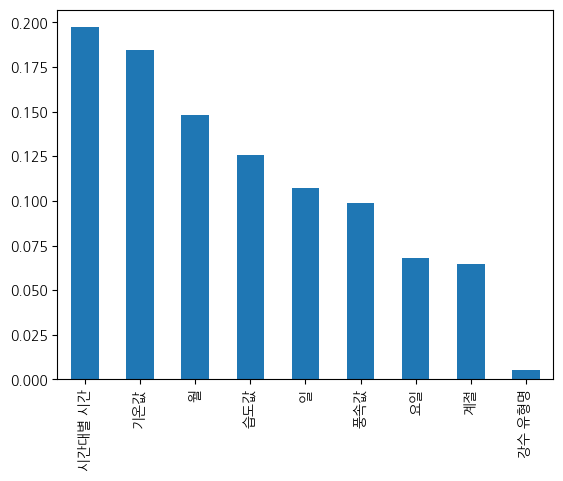

--------------------------------------------------------------------------------
XGB 정확도 : 정확도 0.1378
XGB Feature_importances


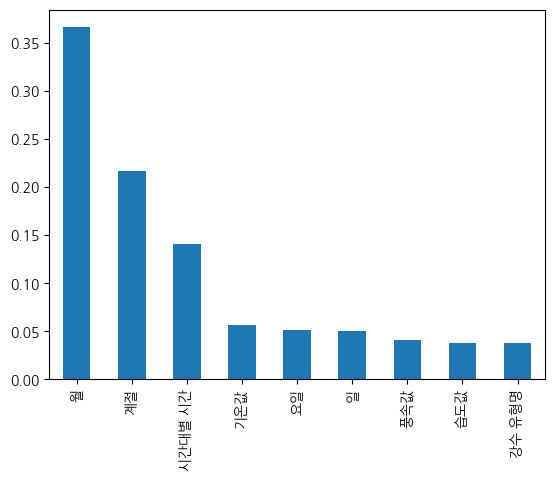

--------------------------------------------------------------------------------
LGBM 정확도 : 정확도 0.5543
LGBM Feature_importances


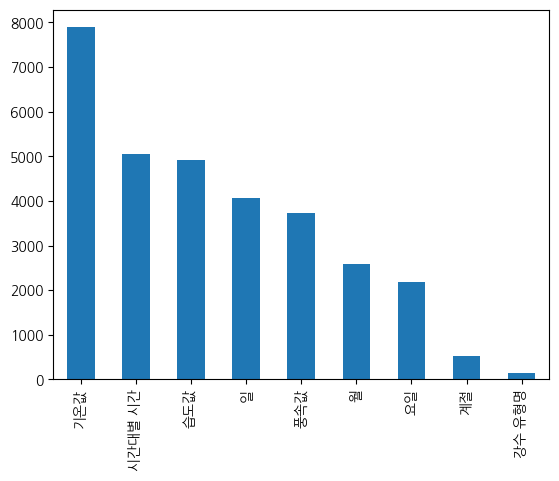

In [19]:
### 그리드 적용 x

## DecisionTree
make_dt(ic)

print('-'*80)

## RandomForest
make_rf(ic, grid = False)

print('-'*80)

## Xgboost
make_xgb(ic, incheon = True, grid = False)

print('-'*80)

## Lgbm
make_lgbm(ic, grid = False)

## 결과
'''
DT 정확도 : 정확도 0.6152
RF 정확도 : 정확도 0.6848
XGB 정확도 : 정확도 0.1378
LGBM 정확도 : 정확도 0.5543
'''

In [20]:
### 그리드 적용

## RandomForest
make_rf(ic, grid = True)

print('-'*80)

## Xgboost
make_xgb(ic, incheon = True, grid = True)

print('-'*80)

## Lgbm
make_lgbm(ic, grid = True)

## 결과
'''
RF_100 정확도:  정확도 0.6921
RF_150 정확도:  정확도 0.6927
RF_200 정확도:  정확도 0.6939
RF_250 정확도:  정확도 0.697
--------------------------------------------------------------------------------
XGB_100_3_0.1 정확도:  정확도 0.153
XGB_100_4_0.1 정확도:  정확도 0.1506
XGB_100_5_0.1 정확도:  정확도 0.1445
XGB_100_6_0.1 정확도:  정확도 0.1482
XGB_100_7_0.1 정확도:  정확도 0.1463
XGB_150_3_0.1 정확도:  정확도 0.147
XGB_150_4_0.1 정확도:  정확도 0.1482
XGB_150_5_0.1 정확도:  정확도 0.1433
XGB_150_6_0.1 정확도:  정확도 0.147
XGB_150_7_0.1 정확도:  정확도 0.1427
XGB_200_3_0.1 정확도:  정확도 0.1488
XGB_200_4_0.1 정확도:  정확도 0.1476
XGB_200_5_0.1 정확도:  정확도 0.1445
XGB_200_6_0.1 정확도:  정확도 0.1409
XGB_200_7_0.1 정확도:  정확도 0.1433
XGB_250_3_0.1 정확도:  정확도 0.1494
XGB_250_4_0.1 정확도:  정확도 0.1457
XGB_250_5_0.1 정확도:  정확도 0.1433
XGB_250_6_0.1 정확도:  정확도 0.1409
XGB_250_7_0.1 정확도:  정확도 0.1402
--------------------------------------------------------------------------------
LGBM_100_3_0.1 정확도:  정확도 0.6762
LGBM_100_4_0.1 정확도:  정확도 0.6488
LGBM_100_5_0.1 정확도:  정확도 0.5927
LGBM_100_6_0.1 정확도:  정확도 0.6457
LGBM_100_7_0.1 정확도:  정확도 0.5768
LGBM_150_3_0.1 정확도:  정확도 0.6823
LGBM_150_4_0.1 정확도:  정확도 0.653
LGBM_150_5_0.1 정확도:  정확도 0.6024
LGBM_150_6_0.1 정확도:  정확도 0.6561
LGBM_150_7_0.1 정확도:  정확도 0.5598
LGBM_200_3_0.1 정확도:  정확도 0.6854
LGBM_200_4_0.1 정확도:  정확도 0.6537
LGBM_200_5_0.1 정확도:  정확도 0.6098
LGBM_200_6_0.1 정확도:  정확도 0.653
LGBM_200_7_0.1 정확도:  정확도 0.5415
LGBM_250_3_0.1 정확도:  정확도 0.6829
LGBM_250_4_0.1 정확도:  정확도 0.6512
LGBM_250_5_0.1 정확도:  정확도 0.6085
LGBM_250_6_0.1 정확도:  정확도 0.6537
LGBM_250_7_0.1 정확도:  정확도 0.347
'''

RF_100 정확도:  정확도 0.6921
RF_150 정확도:  정확도 0.6927
RF_200 정확도:  정확도 0.6939
RF_250 정확도:  정확도 0.697
--------------------------------------------------------------------------------
XGB_100_3_0.1 정확도:  정확도 0.153
XGB_100_4_0.1 정확도:  정확도 0.1506
XGB_100_5_0.1 정확도:  정확도 0.1445
XGB_100_6_0.1 정확도:  정확도 0.1482
XGB_100_7_0.1 정확도:  정확도 0.1463
XGB_150_3_0.1 정확도:  정확도 0.147
XGB_150_4_0.1 정확도:  정확도 0.1482
XGB_150_5_0.1 정확도:  정확도 0.1433
XGB_150_6_0.1 정확도:  정확도 0.147
XGB_150_7_0.1 정확도:  정확도 0.1427
XGB_200_3_0.1 정확도:  정확도 0.1488
XGB_200_4_0.1 정확도:  정확도 0.1476
XGB_200_5_0.1 정확도:  정확도 0.1445
XGB_200_6_0.1 정확도:  정확도 0.1409
XGB_200_7_0.1 정확도:  정확도 0.1433
XGB_250_3_0.1 정확도:  정확도 0.1494
XGB_250_4_0.1 정확도:  정확도 0.1457
XGB_250_5_0.1 정확도:  정확도 0.1433
XGB_250_6_0.1 정확도:  정확도 0.1409
XGB_250_7_0.1 정확도:  정확도 0.1402
--------------------------------------------------------------------------------
LGBM_100_3_0.1 정확도:  정확도 0.6762
LGBM_100_4_0.1 정확도:  정확도 0.6488
LGBM_100_5_0.1 정확도:  정확도 0.5927
LGBM_100_6_0.1 정확도:  정확도 0.645